Sergio:  make sure config and sim_setup are no longer used in your code. 

only use files in current directory. create new directory to make sure none of the other files are used (eg do not use asdditional.add.xml)

Currently removed all sources of stochasticity (so running w/ different seeds still yields the same outputs). For paper results, we should add back stochasticiy (eg change speedDev parameter in additional xml file to a value >0)

# Macros / utils / params

In [1]:
import xml.etree.ElementTree as ET
import json
from pathlib import Path
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Parameters

Simulations are defined to start at time 0 and end at time 'od_duration_seconds'.

Code assumes a warmup time and a cooldown time of 0sec. 

Meso (instead of micro) simulations are run to reduce compute times

In [62]:
base_path = '/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO'
taz2edge_xml = 'taz_new.xml'
net_xml = 'SFO.net.xml'
fixed_routes_xml = f'{base_path}/5hr_route_choice_set.csv'

In [114]:
od_duration_seconds = 5*60 
# duration of sample time for simulation output statistics
simulation_stat_freq_sec = od_duration_seconds
sim_end_time = od_duration_seconds
additional_xml = f'additional.add_statfreq{od_duration_seconds}.xml'

In [171]:
# suffix of simulation output edge file
EDGE_OUT_STR = 'edge_data_SFO.xml'
TRIPS2ODS_OUT_STR = 'trips.xml'
SUMO_PATH = '/usr/local/opt/sumo/share/sumo'

## Functions / utils

In [4]:
# routes_df = pd.read_csv(fixed_routes_xml, header=0, index_col=0)
# # casting to strings since taz2edge tazes are strings
# routes_df['fromTaz'] = routes_df['fromTaz'].astype(str)
# routes_df['toTaz'] = routes_df['toTaz'].astype(str)

In [6]:
def iter_str(author, row_str):
    author_attr = author.attrib
    for doc in author.iter(row_str):
        doc_dict = author_attr.copy()
        doc_dict.update(doc.attrib)
        doc_dict['data'] = doc.text
        yield doc_dict

def xml2df_str(root, row_str):
    return pd.DataFrame(list(iter_str(root, row_str)))

In [9]:
# only keep ODs that are in initial OD set
def is_in_OD_set(orig, dest):
    return ((routes_df.fromTaz==orig) and (routes_df.toTaz==dest))

In [750]:
# update the trips file generated by od2trips to get to and from (ie start and end) edges
# that are consistent with a given route choice set. 
# do not use to_xml to print the trips xml file bc we need to guarantee that trips are printed with sorted depart times, as required by sumo
def update_trip_routes(in_trips_xml, out_trips_xml, rtes_df):

    tree = ET.parse(in_trips_xml)
    root = tree.getroot()
    trips_df =  xml2df_str(root, 'trip')
    #rtes_df = pd.read_csv(fixed_routes_xml, header=0, index_col=0)
    # cast tazes to strings to be consistent w/ trips file
    rtes_df['fromTaz'] = rtes_df['fromTaz'].astype(str)
    rtes_df['toTaz'] = rtes_df['toTaz'].astype(str)    
    
    trips_df = trips_df.drop(columns=['to','from'])

    # only keep ODs that are in initial OD set
    trips_df =  trips_df.merge(rtes_df[['fromTaz','toTaz','start_edge','last_edge']], on=['fromTaz','toTaz'], how='inner')    
    trips_df = trips_df.rename(columns={'start_edge':'from','last_edge':'to'})
    

    trips_df['depart_float'] = [float(elem) for elem in trips_df['depart']]
    trips_df = trips_df.sort_values(by='depart_float')

    # write updated tree
    trips_df.to_xml(out_trips_xml, 
                      attr_cols=['id','depart','from','to','type','fromTaz','toTaz','departLane','departSpeed'], 
                      root_name='routes', row_name='trip', index=False)   

    
    # # rewrite tree using elementTree.write so that trips are printed with sorted depart times, as required by sumo
    # print('Sorting updated trips file by  departure time, as required by sumo')
    # root = tree.getroot()
    # tree = ET.parse(out_trips_xml)
    # # sort the first layer
    # root[:] = sorted(root, key=lambda child: (child.tag,child.get('trip')))
    # xmlstr = ET.tostring(root, encoding="utf-8", method="xml")

In [729]:
def create_taz_xml(file_xml, od_df, od_end_time_seconds, base_dir):
    xml_out = f'{base_dir}/{file_xml}'
    od_df.to_xml(xml_out, 
                attr_cols=['from','to','count'], 
                root_name='interval', row_name='tazRelation', index=False)
    
    # define interval attributes
    tree = ET.parse(xml_out)
    root = tree.getroot()
    root.set('id',"DEFAULT_VEHTYPE")
    root.set('begin',"0")
    root.set('end',str(od_end_time_seconds))
    
    # update root node and write new od
    new_root = ET.Element('data')
    new_root.insert(0, root)
    tree = ET.ElementTree(new_root)
    #tree.setroot(new_root)
    tree.write(xml_out)    
    print('Created ', xml_out)


In [730]:
def create_od_xml(current_od, base_od_df, file_od, od_end_time_seconds, base_dir):
    # create OD xml file 

    print(f'total expected GT demand: {np.sum(current_od)}')
    base_od_df['count'] = current_od
    # round to 1 decimal point
    base_od_df['count'] = [round(elem, 1) for elem in base_od_df['count']]     
    base_od_df = base_od_df.rename(columns={'fromTaz':'from', 'toTaz':'to'})        
    create_taz_xml(file_od, base_od_df, od_end_time_seconds, base_dir)

In [751]:
def simulate_od(od_xml, prefix_output, base_dir, net_xml, taz2edge_xml, 
                additional_xml,
                routes_df,
                sim_end_time,
                sim_start_time=0, seed=0):
    # the [:-4] is to remove the initial xml suffix
    trip_output_file_od2trips_before = f'{base_dir}/{prefix_output}_{TRIPS2ODS_OUT_STR[:-4]}_beforeRteUpdates.xml'
    trip_output_file_od2trips_after = f'{base_dir}/{prefix_output}_{TRIPS2ODS_OUT_STR}'
    od2trips_cmd = (
        #f"od2trips --no-step-log  --spread.uniform "
        f"od2trips  --spread.uniform "
        #Loads TAZ (districts)
        f"--taz-files {base_dir}/{taz2edge_xml} " 
        # Loads O/D-matrix in tazRelation format fromFILE(s)
        f"--tazrelation-files {base_dir}/{od_xml} "
        # Writes trip definitions into FILE
        f"-o {trip_output_file_od2trips_before}" 
    )


    # Run SUMO to generate outputs
    sumo_run = (
        # Prefix which is applied to all output files. 
        f"sumo --output-prefix {prefix_output}_ " 
        # Do not check whether routes are connected
        f"--ignore-route-errors=true "
        # Load road network description from FILE
        f"--net-file={base_dir}/{net_xml} "
        # Load routes descriptions from FILE(s)
        f"--routes={trip_output_file_od2trips_after} "
        #  -b Defines the begin time in seconds; The simulation starts at this time
        # -e Defines the end time in seconds; The simulation ends at this time
        f"-b {sim_start_time} -e {sim_end_time} "
        # Load further descriptions from FILE(s)
        f"--additional-files {base_dir}/{additional_xml} "
        f"--duration-log.statistics "
        f"--xml-validation never "
        # Save single vehicle route info into FILE
        f"--vehroutes {base_dir}/routes.vehroutes.xml "
        f"--verbose "
        # Disables output of warnings
        f"--no-warnings "
        # Faster simulation (i.e. less detailed)
        f"--mesosim true "
        f"--seed {seed}"
    
    )

    try:
        print(od2trips_cmd)
        os.system(od2trips_cmd)
    except:
        print("Unable to create trips file in od2trips")

    # update to and from edges of the trips file generated by od2trips to 
    # make it consistent with the given route choice file
    update_trip_routes(trip_output_file_od2trips_before, trip_output_file_od2trips_after, routes_df)

    try:
        print("###### Running SUMO #######")
        print(f'Seed {seed}')
        print(sumo_run)
        os.system(sumo_run)
    except:
        print("Unable to run sumo")


In [734]:
def parse_loop_data_xml_to_pandas(base_dir,sim_edge_file,prefix_output):
    """Read sumo_edge output file. Produce aggregate edge statistics. 
    """

    output_file =f'{base_dir}/{prefix_output}_loopOutputs.csv'
    ## See output explanation:
    # https://sumo.dlr.de/docs/Simulation/Output/Lane-_or_Edge-based_Traffic_Measures.html#generated_output

    data2csv = (
        f"python {SUMO_PATH}/tools/xml/xml2csv.py "
        f"{sim_edge_file} "
        f"-o {output_file}"
        )
    
    os.system(data2csv)
    
    df_trips = pd.read_csv(output_file, sep=";", header=0)

    # edge flow in vehicles per hour
    ## edge speed is given in m/s
    ## edge_density is given in no. of vehicles/km

    df_trips['interval_nVehContrib'] = df_trips['edge_arrived'] + df_trips['edge_left']
    #df_trips['interval_nVehContrib'] = 3.6*df_trips['edge_speed']*df_trips['edge_density']


    #df_trips['EdgeID'] = df_trips['edge_id']

    # edge speed is given in m/s
    # computed only for edges that have departed flow
    df_trips['interval_harmonicMeanSpeed'] = df_trips[df_trips['interval_nVehContrib']>0]['edge_speed']
    
    # exclude warm-up period
    #df_trips = df_trips[df_trips['interval_begin']>warm_up_sec]

    # aggregate the rest of the time intervals
    df_agg = df_trips.groupby(by=['edge_id'], as_index=False).agg(
        {'interval_nVehContrib':np.sum, 'interval_harmonicMeanSpeed':np.mean})


    return df_agg, df_trips, output_file

In [735]:
input_path = '/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/metadata/'

In [10]:
#from sumo_python.helpers.load_experiment_metadata import load_experiment_metadata

In [13]:
def load_experiment_metadata(input_path: str):

    config = json.load(open(input_path + "/config.json"))
    #base_path = Path(base_path)
    config["SUMO"] = Path(config["SUMO"])
    # [CO] updated simulation setup to use OD scenario #4: 42-dimensional  + low congestion.
    sim_setup = json.load(open(input_path + "simulation_setups_co_gt.json"))

    return config, sim_setup


In [14]:
config, _ = load_experiment_metadata(input_path)
config

{'NETWORK': '/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO',
 'SUMO': PosixPath('/usr/local/opt/sumo/share/sumo')}

In [246]:
def compute_nrmse_counts_all_edges(df_true, df_simulated):
    # Merge simulated output with ground truth
    df1 = df_true\
        .merge(df_simulated, on=['edge_id'],
        suffixes=('_GT', '_sim'), how='left')
    
    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
        
    df1['diff_square'] = (
        df1['interval_nVehContrib_GT'] - df1['interval_nVehContrib_sim']
        )**2
    
    n = df1.shape[0]
    print('number of GT edges:',n)
    #print(df_true.shape[0])
    #print(df_simulated.shape[0])
    RMSN = np.sqrt(n*(df1['diff_square'].sum()))/df1['interval_nVehContrib_GT'].sum()

    return RMSN

# Generate fixed route choice set

In [5]:

def run_sumo_generate_route_choice(base_dir, prefix_output, seed):
    # Run SUMO to generate route choice set
    # hard-coded inputs: net file, additional file, trip file, beginning and end times (simulating for 5 hours), vehroutes output file
    sumo_run = (
        # Prefix which is applied to all output files. 
        f"sumo --output-prefix {prefix_output}_ " 
        # Do not check whether routes are connected
        f"--ignore-route-errors=true "
        # Load road network description from FILE
        f"--net-file={base_dir}/SFO.net.xml "
        # Load routes descriptions from FILE(s)
        f"--routes=/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/notebooks/calibrate_ods/network/SFO/trips24h_smoothed.rou.xml "
        #  -b Defines the begin time in seconds; The simulation starts at this time
        # -e Defines the end time in seconds; The simulation ends at this time
        f"-b 0 -e 18000 "
        # Load further descriptions from FILE(s)
        f"--additional-files {base_dir}/additional.add.xml "
        f"--duration-log.statistics "
        f"--xml-validation never "
        # Save single vehicle route info into FILE
        f"--vehroutes {base_dir}/5hr_sim_routes.vehroutes.xml "
        f"--verbose "
        # Disables output of warnings
        f"--no-warnings "
        # Faster simulation (i.e. less detailed)
        f"--mesosim true "
        # Faster simulation (i.e. less detailed)
        f"--seed {seed} "
    
    )
        # f"--seed {seed}"

    print("###### Running SUMO #######")
    print(sumo_run)
    os.system(sumo_run)


Simulate 5hr of initial SFO (downloaded demand) to generate a sample of feasible routes

In [30]:
# simulating GT. 
start = time.time() 
run_sumo_generate_route_choice(base_path, prefix_output="5hr_sim", seed=0)
end = time.time()


###### Running SUMO #######
sumo --output-prefix 5hr_sim_ --ignore-route-errors=true --net-file=/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/SFO.net.xml --routes=/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/notebooks/calibrate_ods/network/SFO/trips24h_smoothed.rou.xml -b 0 -e 18000 --additional-files /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/additional.add.xml --duration-log.statistics --xml-validation never --vehroutes /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/5hr_sim_routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0 
Loading net-file from '/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/SFO.net.xml' ... 
done (18735ms).
Loading additional-files from '/Users/osorio/HEC/Research/Group/ExternalCo

In [31]:
(end-start)/60 # duration of simulation in minutes

45.05509845415751

Get the set of sampled routes for each OD pair

In [7]:
# check total demand of gt OD
tree = ET.parse(f'{base_path}/5hr_sim_5hr_sim_routes.vehroutes.xml')
root = tree.getroot()
veh_df = xml2df_str(root, 'vehicle')

In [39]:
veh_df.loc[70051]['route_edges']

'741957040 394183815#0 394183821 -417312851#2 -30929714#2 -741957043#2 -407968242#0 417724778#1 -238228475#13 -686695366#2 -686695366#0 392518794#0 451031963#1 406600746#0 392517620 392517618#0 392517617#0 392516418#0 392516420#1 692328668 392516417#0 392516419#1 505809629 392516153#0 392521082#0 392521080 392516156#0 392521078#0 392521078#1 392521083#0 392521083#2 392513592 416946555#0 416946555#1 698786700#0 698786699#0 698786699#1 698786699#2 45313846#0 45313846#1 416958859#0 416968442#1 416968505 416958925 416968472#0 -6370509#0 6370509#0'

The vehicle entries do not have the toTaz information. Retrieve the toTaz information from the taz definitions

In [46]:
# same trip file as used as input for above simulation
init_trip_file = "/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/notebooks/calibrate_ods/network/SFO/trips24h_smoothed.rou.xml"
tree = ET.parse(init_trip_file)
root = tree.getroot()
trip_df = xml2df_str(root, 'trip')

In [47]:
trip_df.head()

,id,depart,departLane,departSpeed,from,fromTaz,to,trip_toTaz,data
0,31175,7213.23,best,max,415860386#8,506305,505169340#1,502002,None
1,15277,7227.5,best,max,655486440,423902,-6395821#1,407200,None
2,34662,7238.04,best,max,317380892#0,511704,52429256#6,507702,None
3,14064,7250.96,best,max,6346767#0,409000,28436936#0,400600,None
4,18941,7251.63,best,max,730896575#0,440301,-573924686#1,609100,None


In [50]:
veh_trip = veh_df.merge(trip_df, on=['id', 'fromTaz'], how='left')

In [52]:
veh_trip = veh_trip.rename(columns={'trip_toTaz':'toTaz'})

In [60]:
del veh_df, trip_df

In [53]:
veh_trip.head()

,{http://www.w3.org/2001/XMLSchema-instance}noNamespaceSchemaLocation,id,depart_x,departLane_x,departSpeed_x,fromTaz,speedFactor,arrival,data_x,route_edges,depart_y,departLane_y,departSpeed_y,from,to,toTaz,data_y
0,http://sumo.dlr.de/xsd/routes_file.xsd,14064,7251.00,best,6.9535,409000,1.0153,7283.00,\n,6346767#0 28436936#0,7250.96,best,max,6346767#0,28436936#0,400600,None
1,http://sumo.dlr.de/xsd/routes_file.xsd,24137,7306.00,best,17.3334,502202,1.1076,7331.00,\n,415826621#0 610303630#0 610303630#1 610303630#...,7305.73,best,max,415826621#0,-415826618#2,502201,None
2,http://sumo.dlr.de/xsd/routes_file.xsd,23071,7300.00,best,16.5393,500800,1.0571,7353.00,\n,417913060#2 417913059#0 417913059#2 768291601 ...,7299.16,best,max,417913060#2,-415844080,501900,None
3,http://sumo.dlr.de/xsd/routes_file.xsd,41717,7253.00,best,15.9487,61500,1.1558,7375.00,\n,397267323 99231463#1 -111560682#1 256400251#1 ...,7252.68,best,max,397267323,667569398#2,12302,None
4,http://sumo.dlr.de/xsd/routes_file.xsd,16509,7416.00,best,16.0104,432400,0.8955,7428.00,\n,417254236#3 -6361045#2,7415.47,best,max,417254236#3,-6361045#2,433400,None


<AxesSubplot: >

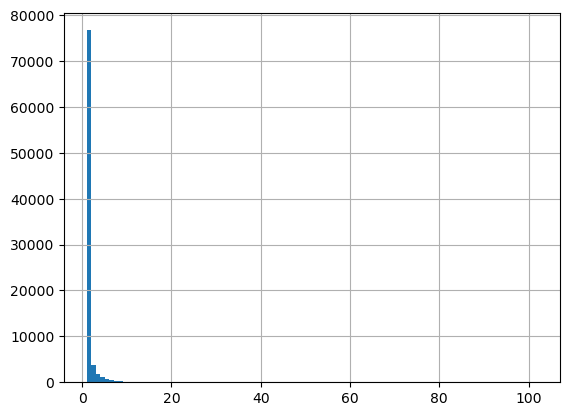

In [65]:
# histogram of # of routes per OD
veh_trip[['fromTaz','toTaz','route_edges']].groupby(by=['fromTaz','toTaz']).size().hist(bins=100)

In [125]:
# based on above histogram most tazes have a single route. 
# for each taz pick one arbitrary route. 
routes_df = veh_trip[['fromTaz','toTaz','route_edges']].groupby(by=['fromTaz','toTaz']).first().reset_index()

In [126]:
# add a route id
routes_df['id'] = routes_df.index

In [127]:
routes_df['start_edge'] =  [elem.split(' ')[0] for elem in routes_df['route_edges']]

In [128]:
routes_df['last_edge'] =  [elem.split(' ')[-1] for elem in routes_df['route_edges']]

In [64]:
# store route choice set as a csv
file_rte = f'{base_path}/5hr_route_choice_set.csv'
routes_df.to_csv(file_rte)

In [65]:
# check
df_tmp = pd.read_csv(file_rte, header=0, index_col=0)

In [66]:
df_tmp.head()

,fromTaz,toTaz,route_edges,id,start_edge,last_edge
0,10100,10400,28518678#1 279611139 8918949#0 399163465#1 706...,0,28518678#1,-148846998#1
1,10100,10500,27570786#5 -27054184#4 -27054184#2 -27054184#0...,1,27570786#5,397140734
2,10100,105000,399163469#1 399163469#2 254299113#4 254299113#...,2,399163469#1,-12176746#1
3,10100,108100,-706549349#1 -706549349#0 775083030#0 77508303...,3,-706549349#1,394568451
4,10100,108200,-700922945#0 27570802#1 27570802#4 26988007#2 ...,4,-700922945#0,393878244


In [67]:
type(df_tmp.loc[0,'fromTaz'])

numpy.int64

In [132]:
del df_tmp

In [135]:
# check OD pairs are unique
routes_df[['fromTaz','toTaz']].shape, routes_df.shape

((86005, 2), (86005, 6))

## Update taz2edge file
It should on contain start/end (ie to/from) edges that appear in the route choice set. 
This significantly reduces compute times of processing these files in trip2ods.

In [246]:
taz_xml_old = f'{base_path}/taz.xml'
taz2edge_xml =  f'{base_path}/taz_new.xml'

In [249]:
tree = ET.parse(taz_xml_old)
root = tree.getroot()
taz_edges_df =  xml2df_str(root, 'taz')

In [299]:
# casting to strings sincetaz2edge tazes are strings
routes_df2['fromTaz'] = routes_df2['fromTaz'].astype(str)
routes_df2['toTaz'] = routes_df2['toTaz'].astype(str)

In [300]:
taz_edges_df.head()

,id,edges,data
0,10100,-143666206#3 -143666208#2 -143666209#1 -148847...,None
1,10200,-133781783#2 -146155124#1 -146155388#1 -148846...,None
2,10300,-148846997#4 -148846997#7 -148846997#9 -300297...,None
3,10400,-148846998#0 -148846998#1 -148846999#2 -300304...,None
4,10500,-224384010#1 -224384010#1 -26769815#3 -2823160...,None


In [301]:
taz_set = set(list(routes_df2['fromTaz'].values) + list(routes_df2['toTaz'].values))

In [302]:
routes_df2.shape

(86005, 6)

In [303]:
len(taz_set)

1308

In [304]:
taz_edges_df.shape, taz_edges_df[taz_edges_df['id'].isin(taz_set)].shape

((1308, 3), (1308, 3))

In [305]:
# checks all tazes in routes_df2 are in taz_set
bool1 = [elem not in taz_set for elem in routes_df2['fromTaz']]
bool2 = [elem not in taz_set for elem in routes_df2['toTaz']]
print(np.sum(bool1), np.sum(bool2))

0 0


In [306]:
# get only tazes that are in the fixed route choice set
taz_edges_df = taz_edges_df[taz_edges_df['id'].isin(taz_set)]

In tazes define only edges that are start/end (ie to/from) edges in the route choice set

In [348]:
taz_list = []
edge_list = []
for elem in taz_set:
    curr_edge_list = []
    bool1 = (routes_df2.fromTaz == elem)
    if np.sum(bool1)>0:
        curr_edge_list += list(routes_df2.loc[bool1,'start_edge'].drop_duplicates())
    bool1 = (routes_df2.toTaz == elem)
    if np.sum(bool1)>0:
        curr_edge_list += list(routes_df2.loc[bool1,'last_edge'].drop_duplicates())
    if len(curr_edge_list)>0:
        taz_list.append(elem)
        edge_list.append(' '.join(list(set(curr_edge_list))))

In [349]:
taz2edge_new_df = pd.DataFrame(list(zip(taz_list, edge_list)), columns=['id','edges'])

In [350]:
# write updated tree
taz2edge_new_df.to_xml(taz2edge_xml, 
                    attr_cols=['id','edges'], 
                  root_name='tazs', row_name='taz', index=False)    

# Update trip file generated by trip2ods

This function should be called after each trip2ods call

Updates the start and end edges of the trip file so that they match those of the fixed route choice set

In [223]:
in_trips_xml = f'{base_path}/gtv2_od_trips.trips.xml'
out_trips_xml = f'{base_path}/gtv2_od_trips.trips_updated.xml'

In [ ]:
routes_df = pd.read_csv(fixed_routes_xml, header=0, index_col=0)
routes_df['fromTaz'] = routes_df['fromTaz'].astype(str)
routes_df['toTaz'] = routes_df['toTaz'].astype(str)

In [224]:
update_trip_routes(in_trips_xml, out_trips_xml, routes_df)

# Define GT scenario

In [766]:
gt_version_str = 'v4'


# # gt v5:
# mean_od_val = 100
# num_ods = 100

# gt v4:
mean_od_val = 100
num_ods = 10

# # gt v3:
# mean_od_val = 0.05

# # gt v2:
# mean_od_val = 0.5
#num_ods = routes_df.shape[0]


# # gt v1:
# mean_od_val = 100
#num_ods = routes_df.shape[0]


print('if you want to optimize them all (~86k) set num_ods as defined in commented line below')
#num_ods = routes_df.shape[0]

if you want to optimize them all (~86k) set num_ods as defined in commented line below


In [767]:
od_xml = f'gt_od_{gt_version_str}.xml'
file_gt = f'{base_path}/gt_od_{gt_version_str}.xml'
file_gt_edges = f'{base_path}/gt_edges_{gt_version_str}.csv'
prefix_output = f'gt_{gt_version_str}'

## Define GT OD

In [768]:
# define an arbitrary OD
gt_od_vals =  np.random.normal(mean_od_val, scale = mean_od_val/10, size=num_ods)

In [769]:
gt_od_df = routes_df[['fromTaz', 'toTaz']].drop_duplicates().iloc[:num_ods]

In [770]:
gt_od_df.shape

(10, 2)

Write xml file w/ gt od

In [771]:
create_od_xml(gt_od_vals, gt_od_df, od_xml, od_duration_seconds, base_path)

total expected GT demand: 1044.4007271529515
Created  /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/gt_od_v4.xml


## Simulate GT OD

Currently only simulated 5min of traffic to speed up computations. Update for actual experiments to 30min. 

In [772]:
tree = ET.parse(file_gt)
root = tree.getroot()
gt_od_df =  xml2df_str(root, 'tazRelation')

In [773]:
gt_od_df.head()

,from,to,count,data
0,10100,10400,97.4,None
1,10100,10500,114.9,None
2,10100,105000,104.1,None
3,10100,108100,100.0,None
4,10100,108200,109.1,None


In [774]:
gt_od_array = np.array([float(elem) for elem in gt_od_df['count']])

In [775]:
gt_od_array

array([ 97.4, 114.9, 104.1, 100. , 109.1, 106.7,  87.8, 101.1, 113.9,
       109.4])

In [776]:
print(f'total expected GT demand: {np.sum(gt_od_array)}')

total expected GT demand: 1044.3999999999999


In [777]:
prefix_output

'gt_v4'

In [778]:
# simulate gt od
simulate_od(od_xml, prefix_output, base_path, net_xml, taz2edge_xml, 
                additional_xml, routes_df,
                sim_end_time)

od2trips  --spread.uniform --taz-files /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/taz_new.xml --tazrelation-files /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/gt_od_v4.xml -o /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/gt_v4_trips_beforeRteUpdates.xml
Success.time 298.30
###### Running SUMO #######
Seed 0
sumo --output-prefix gt_v4_ --ignore-route-errors=true --net-file=/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/SFO.net.xml --routes=/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/gt_v4_trips.xml -b 0 -e 300 --additional-files /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/additional.add_statfreq300.xml --duration-log.statistics --xm

In [779]:
print('here')

here


## Define GT edges

### Pick GT edges base on the ones that most often appear in simulated routes

Don't use this option as default. Instead use the one below.
Choose this option when you have many ODs that contribute to the same edges. 
Don't do this for if you have few ODs bc most ODs will not impact any of the GT edge statistics (bc they won't have routes that travel through the arbitrarly chosen set of routes)

In [457]:
num_gt_edges = 10

In [455]:
sim_edge_out = f'{base_path}/{prefix_output}_{EDGE_OUT_STR}'
df_edge_gt, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out, prefix_output)

In [456]:
df_edge_gt.head()

,edge_id,interval_nVehContrib,interval_harmonicMeanSpeed
0,-24335486#1,55,11.18
1,-30029708#1,75,11.18
2,-397060249#1,57,11.18
3,-397135720,52,11.18
4,-397264925,54,11.18


In [261]:
df_edge_gt.columns

Index(['edge_id', 'interval_nVehContrib', 'interval_harmonicMeanSpeed'], dtype='object')

In [262]:
gt_edge_data = df_edge_gt.sort_values(by=['interval_nVehContrib'], ascending=False).iloc[:num_gt_edges]

In [263]:
gt_edge_data['edge_id'].values

array(['50690291-AddedOnRampEdge', '661905443', '290080810#4',
       '89782522#1', '417087306#1', '28841117#1', '397119705#0',
       '417087312#6', '415491501#0', '8921141#0'], dtype=object)

In [264]:
# store gt_edge_ids
gt_edge_data.to_csv(file_gt_edges)

### Using all edges as GT edges.

Choose this as the default option for troubleshooting. 
TODO: create GT edges based on GT routes + pick edges that contribute to multiple ODs, while ensuring that all ODs contribute to a GT edge to limit level of underdetermination.

Get simulated edge counts for all edges and GT OD

In [780]:
sim_edge_out = f'{base_path}/{prefix_output}_{EDGE_OUT_STR}'
df_edge_gt, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out, prefix_output)

In [781]:
df_edge_gt.shape

(197, 3)

In [782]:
# picking at edges as GT edges
num_gt_edges = df_edge_gt.shape[0]

In [783]:
num_gt_edges

197

In [784]:
df_edge_gt.head()

,edge_id,interval_nVehContrib,interval_harmonicMeanSpeed
0,-148846998#1,54,6.85
1,-224384010#1,54,13.90
2,-24335486#1,34,11.18
3,-254299125#2,88,13.80
4,-254299128#1,80,11.18


In [785]:
gt_edge_data = df_edge_gt.sort_values(by=['interval_nVehContrib'], ascending=False).iloc[:num_gt_edges]

In [786]:
gt_edge_data['edge_id'].values

array(['8918949#0', '8922283', '88142688', '396935402', '396935396',
       '396935405#2', '397094231', '513970793', '87297168#0',
       '87297168#1', '88396406#1', '88396406#2', '88396406#5',
       '775083030#0', '775083030#1', '408575052', '254299113#4',
       '514604867', '-706549349#1', '204967525#1', '27570786#5',
       '88142687#1', '-27054184#4', '23157849#0', '-27054184#2',
       '-27054184#0', '-255168048#14', '-700922945#0', '85644942#1',
       '359898623#1', '198877615#1', '399163469#1', '-255168048#13',
       '359898622#0', '27570802#1', '399163469#2', '198877615#3',
       '-255168048#9', '408600375#0', '-514650998#4', '28518678#1',
       '27570802#4', '279611139', '85562534#0', '-255168048#3',
       '24335489#1', '30030100#2', '30030100#4', '30030485#4',
       '399163465#1', '30030485#5', '-706549349#0', '-254299125#2',
       '30030485#6', '706534240#1', '24335489#2', '26988007#2',
       '-254982299#1', '254299113#7', '706534240#6', '359898157#0',
       '7065

In [787]:
# store gt_edge_ids
gt_edge_data.to_csv(file_gt_edges)

In [674]:
# # sample code that can be used later to get GT routes

# # get GT OD pairs
# tree = ET.parse(file_gt)
# root = tree.getroot()
# gt_od_df =  xml2df_str(root, 'tazRelation')

# # get the routes of the GT OD pairs
# gt_routes = gt_od_df.merge(routes_df, right_on=['fromTaz', 'toTaz'],  left_on=['from', 'to'], how='left')

# # check there's a single route per OD
# gt_od_df.shape, gt_routes.shape

# Loss function validation

## Check impact of seed

Note: seed impact evaluation was carried out with setup gt_v3

In [206]:
num_seeds = 4
edge_gt_all = []
for s1 in range(1,num_seeds+1):    
    print('seed ',s1)
    curr_prefix = f'{prefix_output}_seed{s1}'
    simulate_od(od_xml, curr_prefix, base_path, net_xml, taz2edge_xml, 
                    additional_xml, routes_df,
                    sim_end_time, seed=s1)
    sim_edge_out = f'{base_path}/{curr_prefix}_{EDGE_OUT_STR}'
    curr_df, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out, curr_prefix)
    edge_gt_all.append(curr_df)
    

seed  1
od2trips  --spread.uniform --taz-files /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/taz_new.xml --tazrelation-files /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/gt_od_v3.xml -o /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/gt_v3_seed1_trips_beforeRteUpdates.xml
Success.time 150.00
###### Running SUMO #######
sumo --output-prefix gt_v3_seed1_ --ignore-route-errors=true --net-file=/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/SFO.net.xml --routes=/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/gt_v3_seed1_trips.xml -b 0 -e 300 --additional-files /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/additional.add_statfreq300.xml --duration-

In [211]:
for s1 in range(num_seeds):
    edge_gt_all[s1] = edge_gt_all[s1].rename(columns={'interval_nVehContrib': f'interval_nVehContrib_seed{s1}',
                                                      'interval_harmonicMeanSpeed' : f'interval_harmonicMeanSpeed_seed{s1}'})
    if s1==0:
        edge_gt_all_df = edge_gt_all[s1].copy()
    else:
        edge_gt_all_df = edge_gt_all_df.merge(edge_gt_all[s1], on='edge_id')

In [212]:
edge_gt_all_df.head()

,edge_id,interval_nVehContrib_seed0,interval_harmonicMeanSpeed_seed0,interval_nVehContrib_seed1,interval_harmonicMeanSpeed_seed1,interval_nVehContrib_seed2,interval_harmonicMeanSpeed_seed2,interval_nVehContrib_seed3,interval_harmonicMeanSpeed_seed3
0,-100134682#0,3,13.80,3,13.80,3,13.80,3,13.80
1,-100134703#0,1,6.85,1,6.85,1,6.85,1,6.85
2,-100400941#2,2,13.80,2,13.80,2,13.80,2,13.80
3,-100400941#5,3,13.80,3,13.80,3,13.80,3,13.80
4,-100677749#8,1,13.80,1,13.80,1,13.80,1,13.80


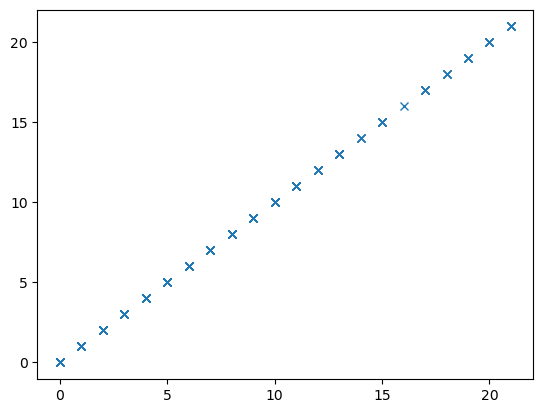

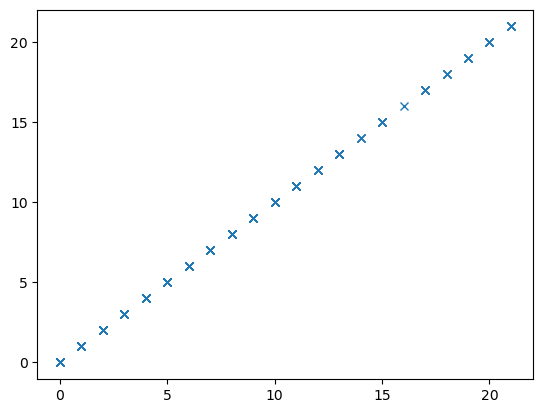

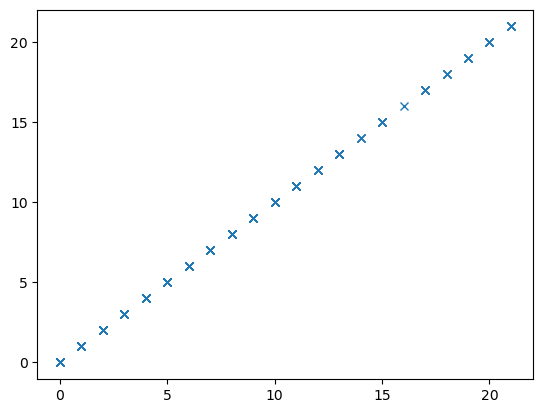

In [213]:
for s1 in range(num_seeds-1):
    plt.figure()                
    plt.plot(edge_gt_all_df['interval_nVehContrib_seed0'], edge_gt_all_df[f'interval_nVehContrib_seed{s1+1}'],'x') 

## Check loss fn of epsilon variations of an OD

Epsilon variation experiments were carried out with setup gt v4

In [788]:
file_gt_edges, file_gt

('/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/gt_edges_v4.csv',
 '/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/gt_od_v4.xml')

In [789]:
tree = ET.parse(file_gt)
root = tree.getroot()
gt_od_df =  xml2df_str(root, 'tazRelation')
gt_od_vals = np.array([float(elem) for elem in gt_od_df['count']])

In [790]:
gt_od_df.head()

,from,to,count,data
0,10100,10400,97.4,None
1,10100,10500,114.9,None
2,10100,105000,104.1,None
3,10100,108100,100.0,None
4,10100,108200,109.1,None


In [791]:
print('total GT demand: ',np.sum(gt_od_vals))

total GT demand:  1044.3999999999999


In [792]:
gt_od_vals

array([ 97.4, 114.9, 104.1, 100. , 109.1, 106.7,  87.8, 101.1, 113.9,
       109.4])

In [793]:
np.random.normal(gt_od_vals, gt_od_vals/30)

array([102.7817942 , 115.24732653, 105.02458856,  99.83342678,
       112.47253806, 106.88613415,  85.82439402, 101.41473415,
       109.91438172, 111.23740652])

In [794]:
base_od = gt_od_df.copy()

In [807]:
num_epsilon_iter = 10
ods_epsilon = []
for o1 in range(num_epsilon_iter):
    print(f"########### Epsilon {o1} ###########")

    file_od_epsilon_xml = f'gt_od_{gt_version_str}_epsilon{o1}.xml'
    prefix_output = f'epsilon{o1}'

    # Generate OD
    curr_od = gt_od_vals.copy()
    curr_od = np.random.normal(gt_od_vals, gt_od_vals/30)

    print(f'total expected GT demand: {np.sum(curr_od)}')

    ###
    # create OD xml file 
    ###
    base_od['count'] = curr_od
    # round to 1 decimal point
    base_od['count'] = [round(elem, 1) for elem in base_od['count']]     
    base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})        
    create_taz_xml(file_od_epsilon_xml, base_od, od_duration_seconds, base_path)
    ods_epsilon.append(curr_od)
    
    # simulate gt od
    simulate_od(file_od_epsilon_xml, prefix_output, base_path, net_xml, taz2edge_xml, 
                additional_xml, routes_df,
                sim_end_time)

########### Epsilon 0 ###########
total expected GT demand: 1054.2311920921916
Created  /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/gt_od_v4_epsilon0.xml
od2trips  --spread.uniform --taz-files /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/taz_new.xml --tazrelation-files /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/gt_od_v4_epsilon0.xml -o /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/epsilon0_trips_beforeRteUpdates.xml
Success.time 298.28
###### Running SUMO #######
Seed 0
sumo --output-prefix epsilon0_ --ignore-route-errors=true --net-file=/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/SFO.net.xml --routes=/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate

In [808]:
print('here')

here


Look into difference of ODs across iterations

In [819]:
od_all_df1 = []
for o1 in range(num_epsilon_iter):
    print(f"########### Epsilon {o1} ###########")
    
    file_od_epsilon_xml = f'gt_od_{gt_version_str}_epsilon{o1}.xml'
    prefix_output = f'epsilon{o1}'
    
    tree = ET.parse(f'{base_path}/{file_od_epsilon_xml}')
    root = tree.getroot()    
    curr_od_df =  xml2df_str(root, 'tazRelation')
    # cast from str to float
    curr_od_df['count'] = [float(elem) for elem in curr_od_df['count']]
    od_all_df1.append(curr_od_df)


########### Epsilon 0 ###########
########### Epsilon 1 ###########
########### Epsilon 2 ###########
########### Epsilon 3 ###########
########### Epsilon 4 ###########
########### Epsilon 5 ###########
########### Epsilon 6 ###########
########### Epsilon 7 ###########
########### Epsilon 8 ###########
########### Epsilon 9 ###########


In [820]:
# total OD demand
for o1 in range(num_epsilon_iter):
    print(np.sum(od_all_df1[o1]['count'].astype(float)))


1054.1999999999998
1043.8
1059.7
1051.6000000000001
1046.3
1032.7
1020.1999999999999
1037.7
1036.8
1042.0


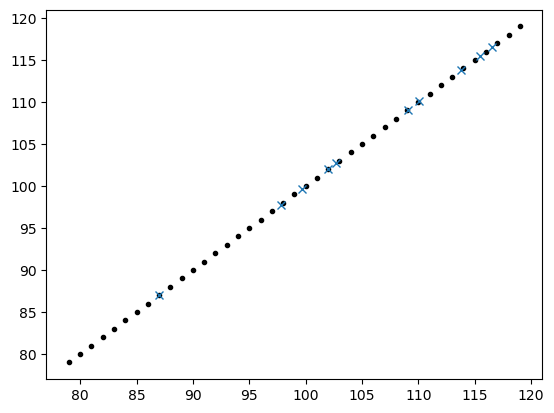

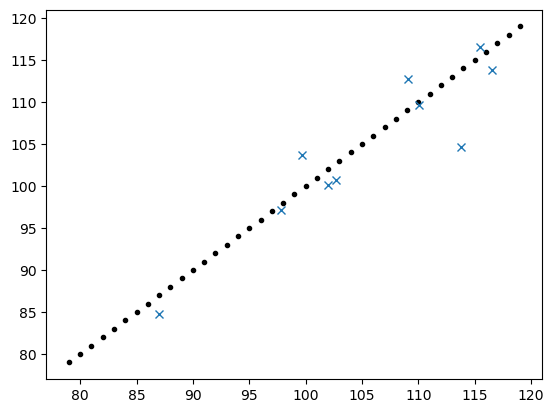

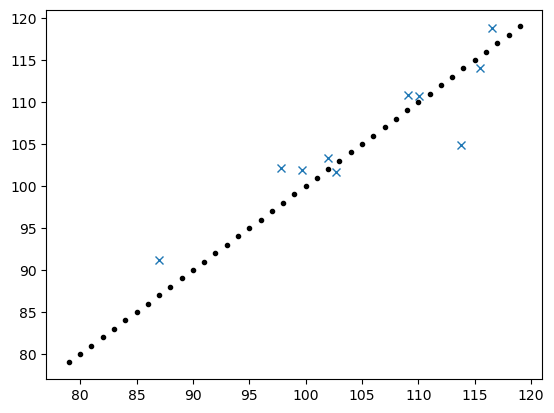

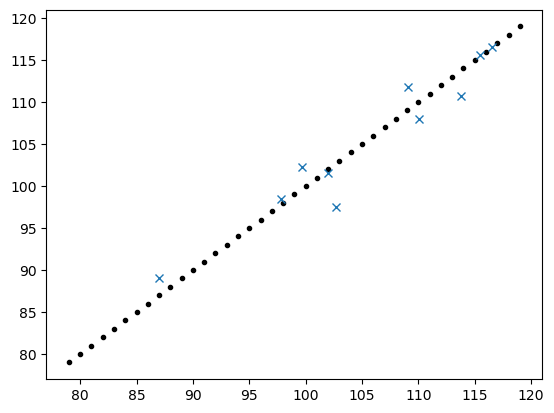

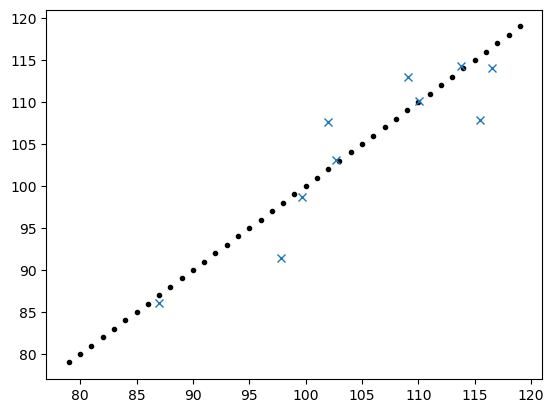

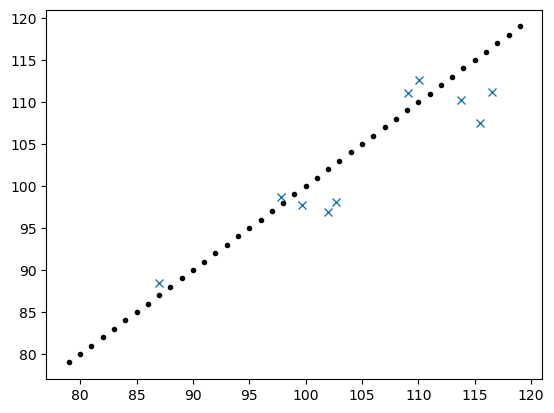

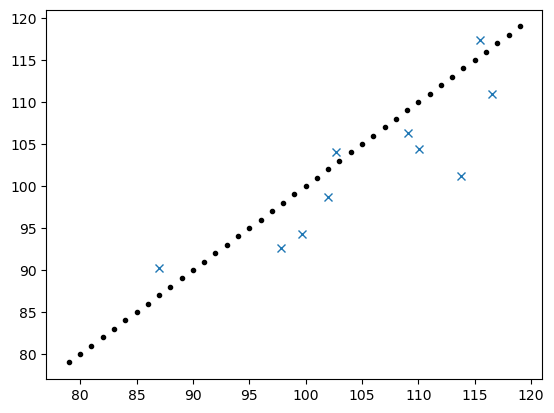

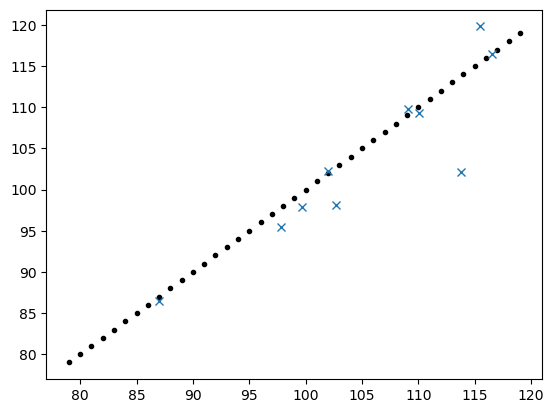

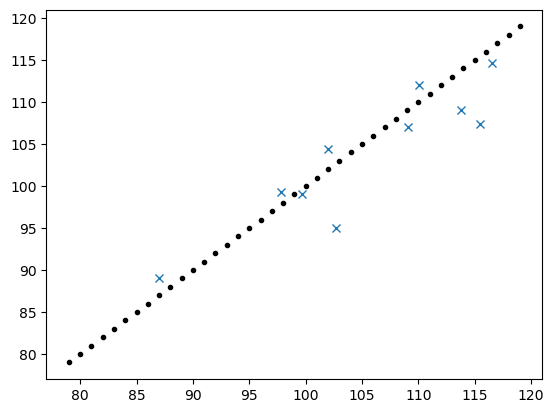

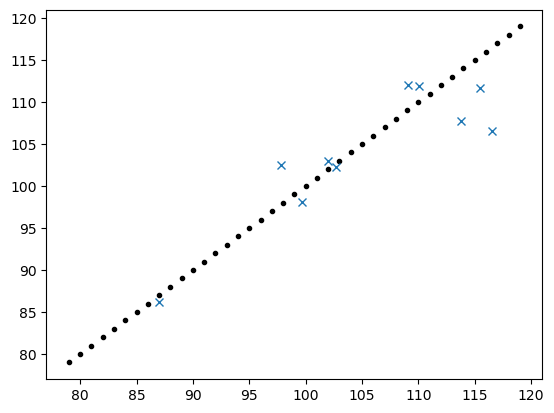

In [821]:
# plotting difference in OD entries
vec1 = np.arange(79,120)
for o1 in range(num_epsilon_iter):
    curr_df2 = od_all_df1[0].merge(od_all_df1[o1], on=['from','to'], how='outer')
    plt.figure()
    plt.plot(vec1, vec1, 'k.')
    plt.plot(curr_df2['count_x'], curr_df2['count_y'], 'x')


In [823]:
# difference in ods
for o1 in range(num_epsilon_iter):
    curr_df2 = od_all_df1[0].merge(od_all_df1[o1], on=['from','to'], how='outer')
    print(np.sum(np.abs(curr_df2['count_x']-curr_df2['count_y'])))


0.0
27.60000000000001
28.100000000000023
18.999999999999986
28.69999999999999
35.30000000000001
46.999999999999986
26.900000000000006
33.0
33.00000000000003


Looking into differences in simulation outputs

In [824]:
edge_epsilon_all = []
for o1 in range(num_epsilon_iter):
    curr_prefix = f'epsilon{o1}'
    sim_edge_out = f'{base_path}/{curr_prefix}_{EDGE_OUT_STR}'
    curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out, curr_prefix)
    edge_epsilon_all.append(curr_loop_stats)


In [826]:
loss_all = []
for o1 in range(num_epsilon_iter):
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, edge_epsilon_all[o1])
    print(curr_loss)
    loss_all.append(curr_loss)


number of GT edges: 197
0.05422891409496773
number of GT edges: 197
0.01395120566004647
number of GT edges: 197
0.07403027650523962
number of GT edges: 197
0.03113907284982883
number of GT edges: 197
0.054185391684991084
number of GT edges: 197
0.07181412038584925
number of GT edges: 197
0.05048904454681055
number of GT edges: 197
0.02354608447194423
number of GT edges: 197
0.06703093156899434
number of GT edges: 197
0.07587944969767638


In [827]:
np.sort(np.array(loss_all))

array([0.01395121, 0.02354608, 0.03113907, 0.05048904, 0.05418539,
       0.05422891, 0.06703093, 0.07181412, 0.07403028, 0.07587945])

number of GT edges: 197
number of GT edges: 197
number of GT edges: 197
number of GT edges: 197
number of GT edges: 197
number of GT edges: 197
number of GT edges: 197
number of GT edges: 197
number of GT edges: 197
number of GT edges: 197


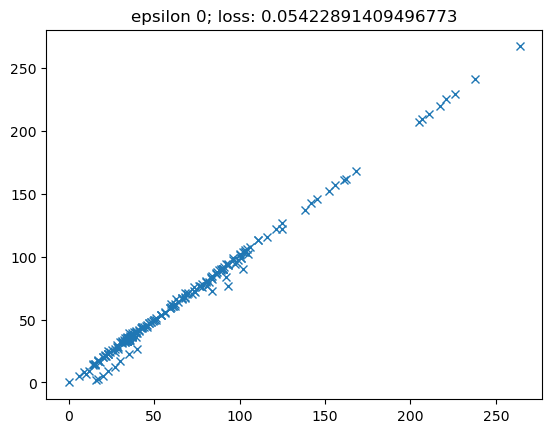

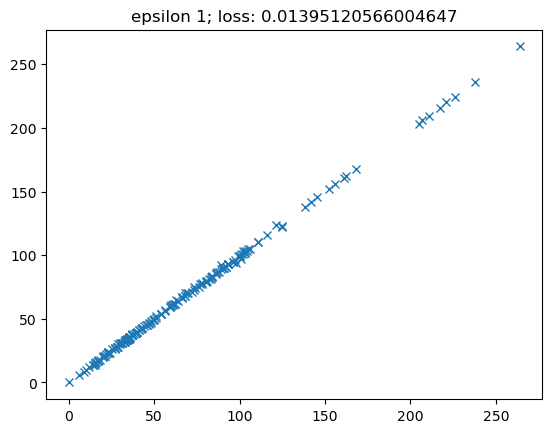

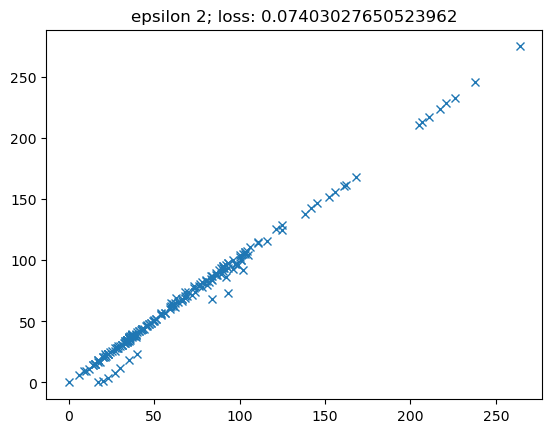

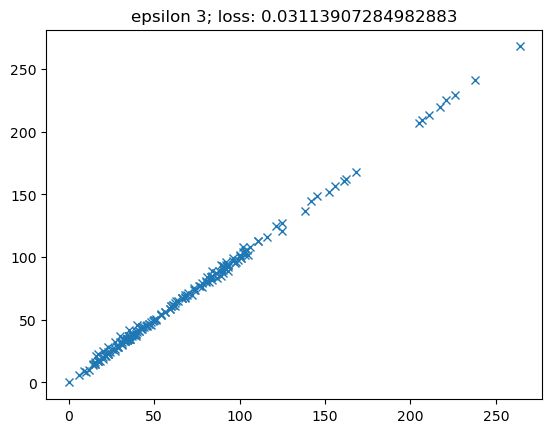

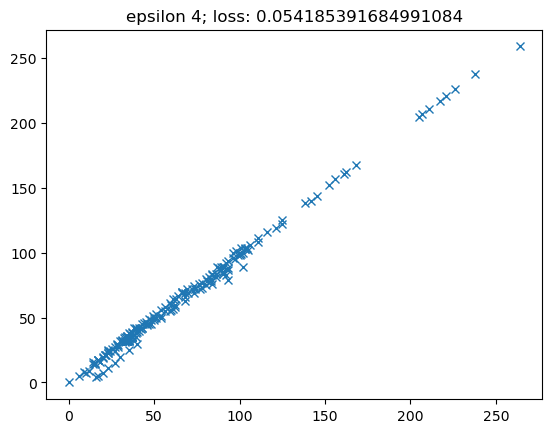

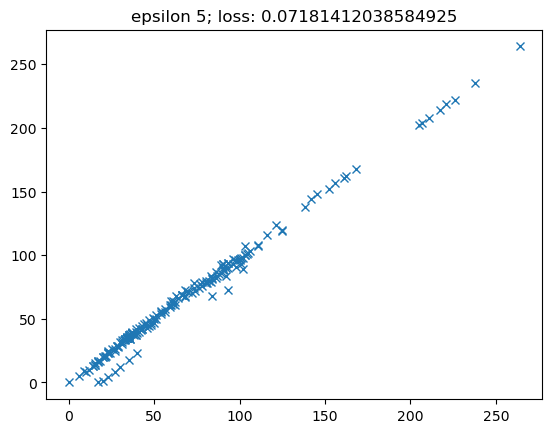

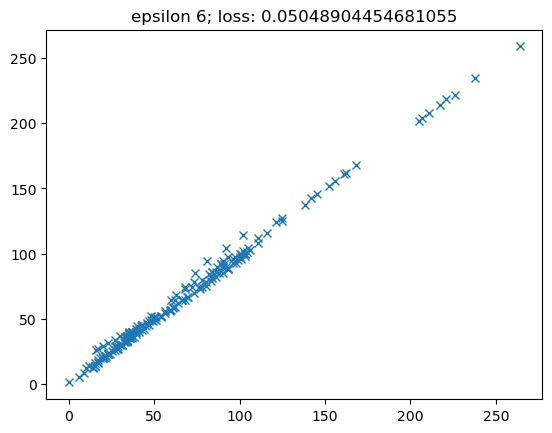

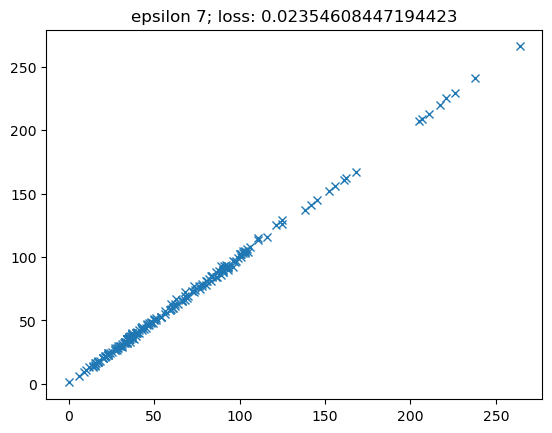

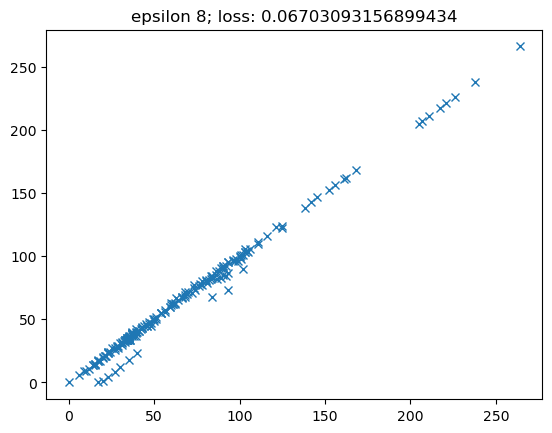

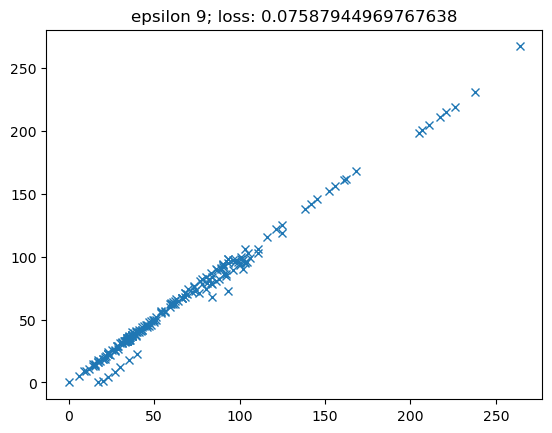

In [815]:
for o1 in range(num_epsilon_iter):
    df1b = gt_edge_data.merge(edge_epsilon_all[o1], on=['edge_id'], how='left')
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, edge_epsilon_all[o1])

    plt.figure()
    plt.plot(df1b.interval_nVehContrib_x, df1b.interval_nVehContrib_y, 'x') 
    plt.title(f'epsilon {o1}; loss: {curr_loss}')


Look into differences in vehicle trips file generated by od2trips

In [816]:
veh_all = []
for o1 in range(num_epsilon_iter):
    print(f"########### Epsilon {o1} ###########")
    
    file_veh_xml = f'epsilon{o1}_routes.vehroutes.xml'    
    tree = ET.parse(f'{base_path}/{file_veh_xml}')
    root = tree.getroot()
    curr_df =  xml2df_str(root, 'vehicle')
    veh_all.append(curr_df)

########### Epsilon 0 ###########
########### Epsilon 1 ###########
########### Epsilon 2 ###########
########### Epsilon 3 ###########
########### Epsilon 4 ###########
########### Epsilon 5 ###########
########### Epsilon 6 ###########
########### Epsilon 7 ###########
########### Epsilon 8 ###########
########### Epsilon 9 ###########


In [817]:
for o1 in range(num_epsilon_iter):
    print(veh_all[o1].drop_duplicates(subset=['fromTaz', 'toTaz']).shape)                                  

(6, 11)
(6, 11)
(6, 11)
(6, 11)
(6, 11)
(6, 11)
(6, 11)
(6, 11)
(6, 11)
(6, 11)


In [818]:
# get total number of vehicle trips generated per OD
veh_grouped = []
for o1 in range(num_epsilon_iter):
    curr_df = veh_all[o1].groupby(by=['fromTaz', 'toTaz']).size().reset_index()
    curr_df = curr_df.rename(columns={0:'tot_count'})
    print(curr_df.shape)
    veh_grouped.append(curr_df)
                                             

(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)


In [409]:
veh_grouped[1].head()

,fromTaz,toTaz,tot_count
0,10300,10500,1
1,10300,10800,1
2,108100,108100,1
3,112100,423902,1
4,11300,12201,1


In [ ]:
base_df1a = edge_epsilon_all[iter_start][edge_epsilon_all[iter_start]['edge_id'].isin(gt_edge_data['edge_id'].values)]
for o1 in range(iter_start,num_epsilon_iter):
    curr_df1a = edge_epsilon_all[o1][edge_epsilon_all[o1]['edge_id'].isin(gt_edge_data['edge_id'].values)]
    df1b = base_df1a.merge(curr_df1a, on=['edge_id'], how='outer')
    
    plt.figure()
    plt.plot(df1b.interval_nVehContrib_x, df1b.interval_nVehContrib_y, 'x') 

In [310]:
for o1 in range(iter_start,num_epsilon_iter):
    curr_df = edge_epsilon_all[iter_start].merge(od_all_df1[o1], on='edge_id')
    plt.figure()
    plt.plot(curr_df.interval_nVehContrib_x, curr_df.interval_nVehContrib_y, 'x') 


KeyError: 'edge_id'

In [277]:
edge_epsilon_all[1].merge(gt_edge_data, on='edge_id')

,edge_id,interval_nVehContrib_x,interval_harmonicMeanSpeed_x,interval_nVehContrib_y,interval_harmonicMeanSpeed_y
0,28841117#1,17,13.80,35,13.80
1,290080810#4,16,13.71,47,13.22
2,397119705#0,14,13.41,34,13.41
3,415491501#0,14,13.80,33,13.80
4,417087306#1,14,13.41,36,13.12
5,417087312#6,15,13.41,33,13.41
6,50690291-AddedOnRampEdge,13,22.35,53,22.35
7,661905443,13,22.35,48,22.35
8,8921141#0,14,13.41,33,13.41
9,89782522#1,16,13.80,42,13.74


number of GT edges: 10
number of GT edges: 10
number of GT edges: 10
number of GT edges: 10
number of GT edges: 10
number of GT edges: 10
number of GT edges: 10
number of GT edges: 10
number of GT edges: 10
number of GT edges: 10


In [272]:
loss_all

[0.6586282190456461,
 0.6577473725304851,
 0.6841973035361939,
 0.5556578992484417,
 0.7155380076686769,
 0.614087330309223,
 0.6811305139896384,
 0.5944723776743325,
 0.6704544238642293,
 0.6255199594461727]

# Main BO loop

In [ ]:
all_ods = []
for o1 in range(2):
    print(f"########### Epoch {o1} ###########")
    file_od_xml = f'test_od_iter{o1}.xml'
    prefix_output = f'test_iter{o1}'

    print('Sergio: replace below call by OD generated by BO')    
    curr_od = np.random.normal(gt_od_vals/10, gt_od_vals/10)
    all_ods.append(curr_od)
    
    # create od xml file
    create_od_xml(curr_od, base_od, file_od_xml, od_duration_sec, base_path):    
                
    # simulate  od
    simulate_od(file_od_xml, prefix_output, base_path, net_xml, taz2edge_xml, 
                additional_xml, routes_df,
                sim_end_time)        

In [704]:
tree = ET.parse(f'{base_path}/gt_v4_trips_beforeRteUpdates.xml')
root = tree.getroot()
trips_df =  xml2df_str(root, 'trip')
#rtes_df = pd.read_csv(fixed_routes_xml, header=0, index_col=0)
# cast tazes to strings to be consistent w/ trips file
routes_df['fromTaz'] = routes_df['fromTaz'].astype(str)
routes_df['toTaz'] = routes_df['toTaz'].astype(str)    

trips_df = trips_df.drop(columns=['to','from'])

# only keep ODs that are in initial OD set
trips_df =  trips_df.merge(routes_df[['fromTaz','toTaz','start_edge','last_edge']], on=['fromTaz','toTaz'], how='inner')    
trips_df = trips_df.rename(columns={'start_edge':'from','last_edge':'to'})

trips_df['depart_float'] = [float(elem) for elem in trips_df['depart']]
trips_df = trips_df.sort_values(by='depart_float')

# write updated tree
trips_df.to_xml(f'{base_path}/TMPgt_v4_trips_beforeRteUpdates.xml', 
                  attr_cols=['id','depart','from','to','type','fromTaz','toTaz','departLane','departSpeed'], 
                  root_name='routes', row_name='trip', index=False)    

# # rewrite tree using elementTree.write so that trips are printed with sorted depart times, as required by sumo
#  # DO NOT USE to_xml to print the trips xml bc it does not preserve ordering of trip df
# print('Sorting updated trips file by  departure time, as required by sumo')
# root = tree.getroot()
# tree = ET.parse(out_trips_xml)
# # sort the first layer
# root[:] = sorted(root, key=lambda child: (child.tag,child.get('trip')))
# xmlstr = ET.tostring(root, encoding="utf-8", method="xml")

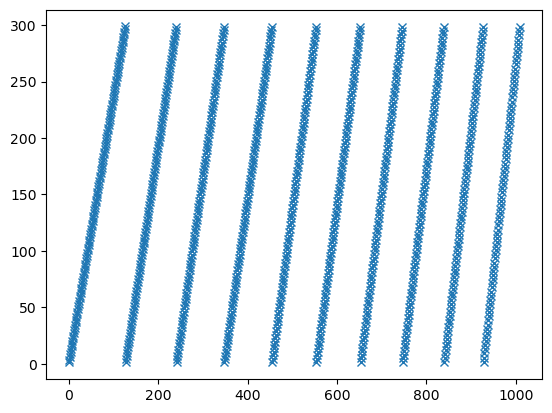

In [705]:
plt.figure()
plt.plot(trips_df.depart_float,'x')